# Install pyspark and read the dataset

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').getOrCreate()
spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the dataset from Google Drive
dataset_path = '/content/drive/My Drive/BigData/googleplaystore.csv'
df =spark.read.csv(dataset_path, header=True, inferSchema=True)
df.show()

+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|    10,000+|Free|    0|      Everyone|        Art & Design|   January 7, 2018|             1.0.0|4.0.3 and up|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|   500,000+|Free|    0|      Everyone|Art & Design;Pret...|  January 15, 2018|             2.0.0|4.0.3 and up|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5,000,000+|Free|    0|      Everyone|        Art & Design|    August 1, 2018|             1.2.4|4.0.3 

# Cleanning and data processing

- remove the extra charechters from columns in install (+), price ($).
- regradin the unit in column size we shoild unite the meagement type to M for all rows.
- check the dublicated rows
- check the null values
- check the invalis values
- transform the catigorical fetuers into numrical fetuer.
- check the Schema
- check the outliers


## remove the extra charechters from columns in install (+), price ($).

In [ ]:
# Import the necessary libraries
from pyspark.sql.functions import regexp_replace

# Remove extra characters from 'Installs' column
df = df.withColumn('Installs', regexp_replace('Installs', '[+,]', ''))

# Remove extra characters from 'Price' column
df = df.withColumn('Price', regexp_replace('Price', '[$]', ''))

# Show the modified DataFrame
df.show()


+--------------------+--------------+------+-------+----+--------+----+-----+--------------+--------------------+------------------+------------------+------------+
|                 App|      Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+--------+----+-----+--------------+--------------------+------------------+------------------+------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|   10000|Free|    0|      Everyone|        Art & Design|   January 7, 2018|             1.0.0|4.0.3 and up|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|  500000|Free|    0|      Everyone|Art & Design;Pret...|  January 15, 2018|             2.0.0|4.0.3 and up|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5000000|Free|    0|      Everyone|        Art & Design|    August 1, 2018|             1.2.4|4.0.3 and up|
|Sketch - 

## regradin the unit in column size we shoild unite the meagement type to M for all rows.

In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType

def parse_size_column(df):
    # Define the UDF to parse and convert the "Size" column
    def parse_size(value):
        if value.endswith("k"):
            return float(value[:-1]) / 1024
        elif value.endswith("M"):
            return float(value[:-1])
        else:
            return None

    # Create the UDF
    parse_size_udf = udf(parse_size, FloatType())

    # Apply the UDF to the "Size" column
    df = df.withColumn("Size_MB", parse_size_udf(col("Size")))

    return df

   # Call the function to parse the "Size" column
df = parse_size_column(df)


In [ ]:
df.show()


+--------------------+--------------+------+-------+----+--------+----+-----+--------------+--------------------+------------------+------------------+------------+-------+
|                 App|      Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver| Android Ver|Size_MB|
+--------------------+--------------+------+-------+----+--------+----+-----+--------------+--------------------+------------------+------------------+------------+-------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|   10000|Free|    0|      Everyone|        Art & Design|   January 7, 2018|             1.0.0|4.0.3 and up|   19.0|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|  500000|Free|    0|      Everyone|Art & Design;Pret...|  January 15, 2018|             2.0.0|4.0.3 and up|   14.0|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5000000|Free|    0|      Everyone|        Art & Design|    August 1, 2018|   

In [ ]:
# Drop the "Size" column
df = df.drop("Size")

# Show the updated DataFrame
df.filter(df['Size_MB'] < 1).show()


+--------------------+------------------+------+-------+--------+----+-----+--------------+----------------+------------------+--------------------+------------+------------+
|                 App|          Category|Rating|Reviews|Installs|Type|Price|Content Rating|          Genres|      Last Updated|         Current Ver| Android Ver|     Size_MB|
+--------------------+------------------+------+-------+--------+----+-----+--------------+----------------+------------------+--------------------+------------+------------+
|   Restart Navigator| AUTO_AND_VEHICLES|   4.0|   1403|  100000|Free|    0|      Everyone| Auto & Vehicles|   August 26, 2014|               1.0.1|  2.2 and up|  0.19628906|
|     Plugin:AOT v5.0|          BUSINESS|   3.1|   4034|  100000|Free|    0|      Everyone|        Business|September 11, 2015|3.0.1.11 (Build 311)|  2.2 and up| 0.022460938|
|Hangouts Dialer -...|     COMMUNICATION|   4.0| 122498|10000000|Free|    0|      Everyone|   Communication| September 2, 201

## check the dublicated rows

In [ ]:
# Count the total number of rows
total_rows = df.count()

# Count the number of unique rows
unique_rows = df.distinct().count()

# Calculate the number of duplicate rows
num_duplicates = total_rows - unique_rows

# Calculate the percentage of duplicate rows
percentage_duplicates = (num_duplicates / total_rows) * 100

# Print the number and percentage of duplicate rows
print("Number of duplicate rows:", num_duplicates)
print("Percentage of duplicate rows:", percentage_duplicates, "%")


Number of duplicate rows: 483
Percentage of duplicate rows: 4.455308550871691 %


the rate of the doplicated rows is 4% so we dicided to drop them.




In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

num_rows_beafore_drop = df.count()
print("Number of rows b4 dropping duplicates:", num_rows_beafore_drop)

# Drop duplicate rows
df = df.dropDuplicates()

# Print the number of rows after dropping duplicates
num_rows_after_drop = df.count()
print("Number of rows after dropping duplicates:", num_rows_after_drop)


Number of rows b4 dropping duplicates: 10841
Number of rows after dropping duplicates: 10358


## check the null values

In [ ]:
from pyspark.sql.functions import col, sum

# Iterate over the columns and check for null values
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    print("Null values in column '{}': {}".format(column, null_count))


Null values in column 'App': 0
Null values in column 'Category': 0
Null values in column 'Rating': 0
Null values in column 'Reviews': 0
Null values in column 'Installs': 0
Null values in column 'Type': 0
Null values in column 'Price': 0
Null values in column 'Content Rating': 1
Null values in column 'Genres': 0
Null values in column 'Last Updated': 0
Null values in column 'Current Ver': 1
Null values in column 'Android Ver': 1
Null values in column 'Size_MB': 1528


In [ ]:
df = df.na.drop(subset=['Content Rating', 'Current Ver', 'Android Ver'])

In [ ]:
from pyspark.sql.functions import col, sum

# Iterate over the columns and check for null values
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    print("Null values in column '{}': {}".format(column, null_count))


Null values in column 'App': 0
Null values in column 'Category': 0
Null values in column 'Rating': 0
Null values in column 'Reviews': 0
Null values in column 'Installs': 0
Null values in column 'Type': 0
Null values in column 'Price': 0
Null values in column 'Content Rating': 0
Null values in column 'Genres': 0
Null values in column 'Last Updated': 0
Null values in column 'Current Ver': 0
Null values in column 'Android Ver': 0
Null values in column 'Size_MB': 1527


the null values in the Size_MB column is replaced with the mean value so it can be used in the analysis insted of dropin them

In [ ]:
from pyspark.sql.functions import mean

# Calculate the mean of the "Size_MB" column
mean_size_mb = df.select(mean(col("Size_MB"))).first()[0]

# Replace null values in "Size_MB" with the mean
df = df.fillna(mean_size_mb, subset=["Size_MB"])

# Verify the replacement
null_count = df.filter(col("Size_MB").isNull()).count()
print("Null values in 'Size_MB' column after replacement:", null_count)


Null values in 'Size_MB' column after replacement: 0


In [ ]:
df.show()

+--------------------+-------------------+------+-------+---------+----+-----+--------------+--------------------+------------------+------------------+------------------+---------+
|                 App|           Category|Rating|Reviews| Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver|       Android Ver|  Size_MB|
+--------------------+-------------------+------+-------+---------+----+-----+--------------+--------------------+------------------+------------------+------------------+---------+
|American Muscle C...|  AUTO_AND_VEHICLES|   3.9|    129|   100000|Free|    0|      Everyone|     Auto & Vehicles|     July 26, 2018|               3.0|        4.1 and up|     35.0|
|    Free Book Reader|BOOKS_AND_REFERENCE|   3.4|   1680|   100000|Free|    0|      Everyone|   Books & Reference|   August 20, 2016|              3.05|      4.0.3 and up|      4.0|
|      OkCupid Dating|             DATING|   4.1| 285726| 10000000|Free|    0|    Mature 1

In [ ]:
from pyspark.sql.functions import isnan
from pyspark.sql.functions import col

# Count the number of rows where Rating is NaN
nan_count = df.filter(isnan("Rating")).count()

# Calculate the percentage
total_count = df.count()
percentage = (nan_count / total_count) * 100

# Display the result
print(f"The percentage of rows with NaN Rating: {percentage:.2f}%")


The percentage of rows with NaN Rating: 14.15%


we have a high percentage of rows with NaN values in the "Rating" column and we cannot simply delete those rows, we dicided to apply imputation

In [ ]:
df.filter(df['Rating'] == 'NaN').count()


1465

In [ ]:
from pyspark.sql.functions import col, mean, when

# Replace "NaN" string values with actual null values
df = df.withColumn('Rating', when(col('Rating') == 'NaN', None).otherwise(col('Rating').cast('double')))

# Calculate the mean of the 'Rating' column
mean_rating = df.select(mean('Rating')).collect()[0][0]

# Fill NaN values in the 'Rating' column with the mean value
df = df.fillna(mean_rating, subset=['Rating'])


In [ ]:
from pyspark.sql.functions import col, isnan

# Count the number of NaN values in the 'Rating' column
nan_count = df.filter(isnan(col('Rating'))).count()

print("Number of NaN values in the 'Rating' column:", nan_count)


Number of NaN values in the 'Rating' column: 0


## check the invalis values



In [ ]:
# List of categorical column names
categorical_columns = ["Category","Rating", "Type", "Content Rating", "Genres"]

check colmns by column

In [ ]:
# check Category col

unique_values = df.select(categorical_columns[0]).distinct().collect()
print("Unique values in column '{}':".format(categorical_columns[0]))
for value in unique_values:
  print(value[0])

Unique values in column 'Category':
EVENTS
COMICS
SPORTS
WEATHER
VIDEO_PLAYERS
AUTO_AND_VEHICLES
PARENTING
ENTERTAINMENT
PERSONALIZATION
HEALTH_AND_FITNESS
TRAVEL_AND_LOCAL
BOOKS_AND_REFERENCE
FOOD_AND_DRINK
PHOTOGRAPHY
BUSINESS
FAMILY
SHOPPING
HOUSE_AND_HOME
GAME
Face
EDUCATION
PRODUCTIVITY
TOOLS
LIFESTYLE
NEWS_AND_MAGAZINES
MEDICAL
COMMUNICATION
MAPS_AND_NAVIGATION
DATING
 traffic jams
LIBRARIES_AND_DEMO
BEAUTY
SOCIAL
FINANCE
ART_AND_DESIGN


In [ ]:
df.filter(df['Category'] == 1.9).count()


0

there is a row in catagory hv the value 1.9 and it is only on row, so we dicided to delete it

In [ ]:
# Filter the DataFrame to exclude the row with "1.9" in the "Category" column
df = df.filter(df["Category"] != "1.9")

# Verify that the row has been deleted
filtered_row_count = df.filter(df["Category"] == "1.9").count()
print("Number of rows with '1.9' in 'Category' column after deletion:", filtered_row_count)


Number of rows with '1.9' in 'Category' column after deletion: 0


In [ ]:
# check Rating col

unique_values = df.select(categorical_columns[1]).distinct().collect()
print("Unique values in column '{}':".format(categorical_columns[1]))
for value in unique_values:
  print(value[0])

Unique values in column 'Rating':
2.4
3.5
2.9
3.7
4.5
1.4
1.7
2.3
3.4
4.9
2.5
1.0
3.1
2.7
4.1
2.2
2.8
4.0
1.9
3.9
3.8
4.2
4.3
4.187861401732484
4.7
3.2
1.6
3.0
2.0
1.2
1.8
1.5
2.6
4.4
4.8
4.6
3.6
5.0
2.1
3.3


In [ ]:
# Check unique values for the "Type" column
unique_values_type = df.select(categorical_columns[2]).distinct().collect()
print("Unique values in column '{}':".format(categorical_columns[2]))
for value in unique_values_type:
    print(value[0])


Unique values in column 'Type':
102248
NaN
Free
Paid
2509


In [ ]:
from pyspark.sql.functions import col

# Count the rows with specified values in "Type" column
filtered_rows = df.filter((col("Type") == "102248") | (col("Type") == "NaN") | (col("Type") == "2509"))
filtered_count = filtered_rows.count()

# Calculate the rate
total_count = df.count()
rate = (filtered_count / total_count) * 100

# Print the count and rate
print("Count of rows with specified values in 'Type' column:", filtered_count)
print("Rate of rows with specified values in 'Type' column: {:.2f}%".format(rate))


Count of rows with specified values in 'Type' column: 3
Rate of rows with specified values in 'Type' column: 0.03%


its only 0.03% of the data so we can delete them without afecting the data

In [ ]:
from pyspark.sql.functions import col

# Filter the DataFrame to exclude the rows with specified values in "Type" column
df = df.filter(~((col("Type") == "102248") | (col("Type") == "NaN") | (col("Type") == "2509")))

# Verify that the rows have been deleted
filtered_count = df.filter((col("Type") == "102248") | (col("Type") == "NaN") | (col("Type") == "2509")).count()
print("Count of rows with specified values in 'Type' column after deletion:", filtered_count)


Count of rows with specified values in 'Type' column after deletion: 0


In [ ]:
# Check unique values for the "Type" column
unique_values_type = df.select(categorical_columns[2]).distinct().collect()
print("Unique values in column '{}':".format(categorical_columns[2]))
for value in unique_values_type:
    print(value[0])


Unique values in column 'Type':
Free
Paid


In [ ]:
# check Content Rating col

unique_values = df.select(categorical_columns[3]).distinct().collect()
print("Unique values in column '{}':".format(categorical_columns[3]))
for value in unique_values:
  print(value[0])

Unique values in column 'Content Rating':
Unrated
Teen
Mature 17+
Everyone 10+
Everyone
Adults only 18+


In [ ]:
# check Content Genres col

unique_values = df.select(categorical_columns[4]).distinct().collect()
print("Unique values in column '{}':".format(categorical_columns[4]))
for value in unique_values:
  print(value[0])

Unique values in column 'Genres':
Video Players & Editors;Creativity
Adventure;Action & Adventure
Education
Trivia
Art & Design;Action & Adventure
Auto & Vehicles
Travel & Local;Action & Adventure
Simulation;Action & Adventure
Education;Pretend Play
Tools;Education
Entertainment
Education;Education
Entertainment;Music & Video
Parenting;Brain Games
Simulation;Pretend Play
Arcade;Action & Adventure
Educational;Creativity
Arcade;Pretend Play
Casual;Music & Video
Adventure
Arcade
Books & Reference;Creativity
Education;Brain Games
Entertainment;Brain Games
Health & Fitness;Action & Adventure
Sports
Entertainment;Action & Adventure
Adventure;Education
Travel & Local
Food & Drink
Sports;Action & Adventure
Parenting;Education
Role Playing
Casual;Pretend Play
Educational;Action & Adventure
Finance
Education;Action & Adventure
Personalization
Educational;Pretend Play
Action;Action & Adventure
Role Playing;Pretend Play
Racing
Comics;Creativity
Board;Action & Adventure
Tools
Board;Brain Games
Life

all vlaus are valid and we can't see any incosistences in both columns mashallah (Content Rating, Genres)

In [ ]:
df.show()


+--------------------+-------------------+------+-------+---------+----+-----+--------------+--------------------+------------------+------------------+------------------+---------+
|                 App|           Category|Rating|Reviews| Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver|       Android Ver|  Size_MB|
+--------------------+-------------------+------+-------+---------+----+-----+--------------+--------------------+------------------+------------------+------------------+---------+
|American Muscle C...|  AUTO_AND_VEHICLES|   3.9|    129|   100000|Free|    0|      Everyone|     Auto & Vehicles|     July 26, 2018|               3.0|        4.1 and up|     35.0|
|    Free Book Reader|BOOKS_AND_REFERENCE|   3.4|   1680|   100000|Free|    0|      Everyone|   Books & Reference|   August 20, 2016|              3.05|      4.0.3 and up|      4.0|
|      OkCupid Dating|             DATING|   4.1| 285726| 10000000|Free|    0|    Mature 1

In [ ]:
# Describe the DataFrame
description = df.describe()

# Show the description
description.show()


+-------+--------------------+--------------+------------------+------------------+--------------------+-----+------------------+---------------+------+-----------------+-------------+------------------+------------------+
|summary|                 App|      Category|            Rating|           Reviews|            Installs| Type|             Price| Content Rating|Genres|     Last Updated|  Current Ver|       Android Ver|           Size_MB|
+-------+--------------------+--------------+------------------+------------------+--------------------+-----+------------------+---------------+------+-----------------+-------------+------------------+------------------+
|  count|               10353|         10353|             10353|             10353|               10353|10353|             10353|          10353| 10353|            10353|        10353|             10353|             10353|
|   mean|                null|          null| 4.187861401732579|406049.37216265814|1.4162553320486816E7| nul

## transform the catigorical fetuers into numrical fetuers

In [ ]:
# import packages
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# conversion
indexer = StringIndexer(inputCol='Category', outputCol='Category_num').fit(df)
indexed_df = indexer.transform(df)

In [ ]:
indexed_df.show()

+--------------------+-------------------+------+-------+---------+----+-----+--------------+--------------------+------------------+------------------+------------------+---------+------------+
|                 App|           Category|Rating|Reviews| Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver|       Android Ver|  Size_MB|Category_num|
+--------------------+-------------------+------+-------+---------+----+-----+--------------+--------------------+------------------+------------------+------------------+---------+------------+
|American Muscle C...|  AUTO_AND_VEHICLES|   3.9|    129|   100000|Free|    0|      Everyone|     Auto & Vehicles|     July 26, 2018|               3.0|        4.1 and up|     35.0|        24.0|
|    Free Book Reader|BOOKS_AND_REFERENCE|   3.4|   1680|   100000|Free|    0|      Everyone|   Books & Reference|   August 20, 2016|              3.05|      4.0.3 and up|      4.0|        16.0|
|      OkCupid Dating|   

schedule that references the numerical values in the Category_num column to their corresponding categories in the Category

In [ ]:
from pyspark.sql import functions as F

# Group the data by Category_num and collect unique categories
schedule = indexed_df.groupBy('Category_num').agg(F.collect_set('Category').alias('Categories'))

# Print the schedule
schedule.show(schedule.count(), truncate=False)


+------------+---------------------+
|Category_num|Categories           |
+------------+---------------------+
|8.0         |[COMMUNICATION]      |
|0.0         |[FAMILY]             |
|7.0         |[LIFESTYLE]          |
|29.0        |[EVENTS]             |
|18.0        |[DATING]             |
|1.0         |[GAME]               |
|25.0        |[LIBRARIES_AND_DEMO] |
|4.0         |[MEDICAL]            |
|23.0        |[ENTERTAINMENT]      |
|31.0        |[PARENTING]          |
|11.0        |[PHOTOGRAPHY]        |
|21.0        |[EDUCATION]          |
|14.0        |[NEWS_AND_MAGAZINES] |
|22.0        |[FOOD_AND_DRINK]     |
|3.0         |[BUSINESS]           |
|19.0        |[VIDEO_PLAYERS]      |
|28.0        |[ART_AND_DESIGN]     |
|2.0         |[TOOLS]              |
|17.0        |[SHOPPING]           |
|27.0        |[HOUSE_AND_HOME]     |
|10.0        |[SPORTS]             |
|30.0        |[COMICS]             |
|13.0        |[SOCIAL]             |
|6.0         |[PERSONALIZATION]    |
|

the type column has been transformd into numrical values 0 and 1.
- 0 referes to Free
- 1 refreres to paid

In [ ]:
# import packages
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# conversion
indexer = StringIndexer(inputCol='Type', outputCol='Type_num').fit(indexed_df)
indexed_df = indexer.transform(indexed_df)

In [ ]:
indexed_df.show()

+--------------------+-------------------+------+-------+---------+----+-----+--------------+--------------------+------------------+------------------+------------------+---------+------------+--------+
|                 App|           Category|Rating|Reviews| Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver|       Android Ver|  Size_MB|Category_num|Type_num|
+--------------------+-------------------+------+-------+---------+----+-----+--------------+--------------------+------------------+------------------+------------------+---------+------------+--------+
|American Muscle C...|  AUTO_AND_VEHICLES|   3.9|    129|   100000|Free|    0|      Everyone|     Auto & Vehicles|     July 26, 2018|               3.0|        4.1 and up|     35.0|        24.0|     0.0|
|    Free Book Reader|BOOKS_AND_REFERENCE|   3.4|   1680|   100000|Free|    0|      Everyone|   Books & Reference|   August 20, 2016|              3.05|      4.0.3 and up|      4.0|   

Content Rating

In [ ]:
# import packages
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# conversion
indexer = StringIndexer(inputCol='Content Rating', outputCol='Content Rating_num').fit(indexed_df)
indexed_df = indexer.transform(indexed_df)

In [ ]:
# Group the data by Category_num and collect unique categories
schedule2 = indexed_df.groupBy('Content Rating_num').agg(F.collect_set('Content Rating').alias('Categories'))

# Print the schedule
schedule2.show(schedule.count(), truncate=False)


+------------------+-----------------+
|Content Rating_num|Categories       |
+------------------+-----------------+
|0.0               |[Everyone]       |
|1.0               |[Teen]           |
|4.0               |[Adults only 18+]|
|3.0               |[Everyone 10+]   |
|2.0               |[Mature 17+]     |
|5.0               |[Unrated]        |
+------------------+-----------------+



Genres

In [ ]:
# import packages
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# conversion
indexer = StringIndexer(inputCol='Genres', outputCol='Genres_num').fit(indexed_df)
indexed_df = indexer.transform(indexed_df)

In [ ]:
# Group the data by Category_num and collect unique categories
schedule3 = indexed_df.groupBy('Genres_num').agg(F.collect_set('Genres').alias('Categories'))

# Print the schedule
schedule3.show(schedule.count(), truncate=False)


+----------+-------------------------------------+
|Genres_num|Categories                           |
+----------+-------------------------------------+
|67.0      |[Educational;Brain Games]            |
|8.0       |[Communication]                      |
|70.0      |[Education;Brain Games]              |
|0.0       |[Tools]                              |
|69.0      |[Education;Action & Adventure]       |
|7.0       |[Lifestyle]                          |
|112.0     |[Role Playing;Brain Games]           |
|108.0     |[Music & Audio;Music & Video]        |
|88.0      |[Art & Design;Pretend Play]          |
|49.0      |[Entertainment;Music & Video]        |
|101.0     |[Comics;Creativity]                  |
|116.0     |[Tools;Education]                    |
|98.0      |[Books & Reference;Creativity]       |
|29.0      |[Racing]                             |
|107.0     |[Lifestyle;Pretend Play]             |
|64.0      |[Casual;Creativity]                  |
|75.0      |[Educational;Action

In [ ]:
columns_to_drop = ["Category", "Type", "Content Rating", "Genres"]
indexed_df = indexed_df.drop(*columns_to_drop)


## check the Schema

In [ ]:
# Check the data type using printSchema
indexed_df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Rating: double (nullable = false)
 |-- Reviews: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)
 |-- Size_MB: float (nullable = false)
 |-- Category_num: double (nullable = false)
 |-- Type_num: double (nullable = false)
 |-- Content Rating_num: double (nullable = false)
 |-- Genres_num: double (nullable = false)



In [ ]:
from pyspark.sql.functions import col

# Convert "Reviews" column to double
indexed_df = indexed_df.withColumn("Reviews", col("Reviews").cast("double"))

# Convert "Installs" column to double
indexed_df = indexed_df.withColumn("Installs", col("Installs").cast("double"))

# Convert "Price" column to double
indexed_df = indexed_df.withColumn("Price", col("Price").cast("double"))

# Check the updated schema
indexed_df.printSchema()


root
 |-- App: string (nullable = true)
 |-- Rating: double (nullable = false)
 |-- Reviews: double (nullable = true)
 |-- Installs: double (nullable = true)
 |-- Price: double (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)
 |-- Size_MB: float (nullable = false)
 |-- Category_num: double (nullable = false)
 |-- Type_num: double (nullable = false)
 |-- Content Rating_num: double (nullable = false)
 |-- Genres_num: double (nullable = false)



in this section we made sure that the datatype of the values are correct in the indexed_df because we will use it later on in the prediction

In [ ]:
# Check the data type using printSchema
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: double (nullable = false)
 |-- Reviews: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)
 |-- Size_MB: float (nullable = false)



In [ ]:
from pyspark.sql.functions import col

# Convert "Reviews" column to double
df = df.withColumn("Reviews", col("Reviews").cast("double"))

# Convert "Installs" column to double
df = df.withColumn("Installs", col("Installs").cast("double"))

# Convert "Price" column to double
df = df.withColumn("Price", col("Price").cast("double"))

# Check the updated schema
df.printSchema()


root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: double (nullable = false)
 |-- Reviews: double (nullable = true)
 |-- Installs: double (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)
 |-- Size_MB: float (nullable = false)



## check the outliers

In [ ]:
indexed_df.show()

+--------------------+------+---------+---------+-----+------------------+------------------+------------------+---------+------------+--------+------------------+----------+
|                 App|Rating|  Reviews| Installs|Price|      Last Updated|       Current Ver|       Android Ver|  Size_MB|Category_num|Type_num|Content Rating_num|Genres_num|
+--------------------+------+---------+---------+-----+------------------+------------------+------------------+---------+------------+--------+------------------+----------+
|American Muscle C...|   3.9|    129.0| 100000.0|  0.0|     July 26, 2018|               3.0|        4.1 and up|     35.0|        24.0|     0.0|               0.0|      30.0|
|    Free Book Reader|   3.4|   1680.0| 100000.0|  0.0|   August 20, 2016|              3.05|      4.0.3 and up|      4.0|        16.0|     0.0|               0.0|      17.0|
|      OkCupid Dating|   4.1| 285726.0|    1.0E7|  0.0|     July 30, 2018|           11.10.1|        4.1 and up|     15.0|   

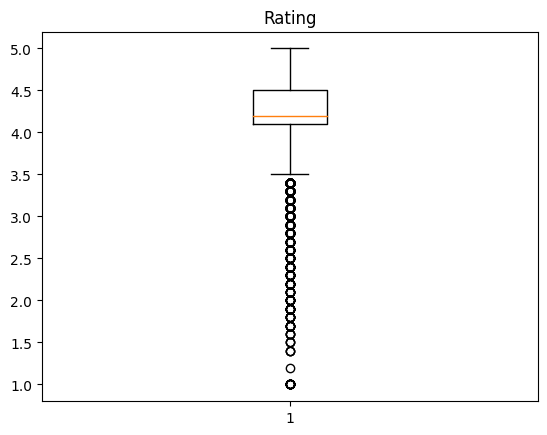

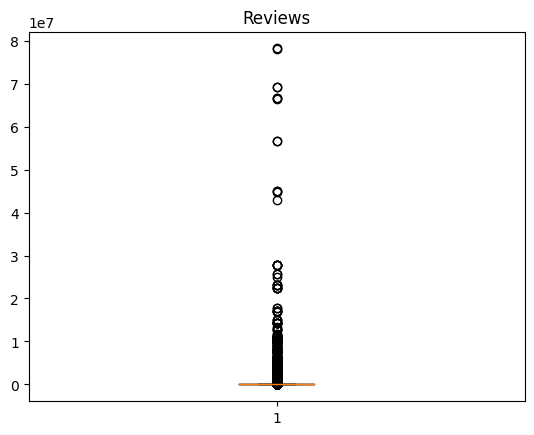

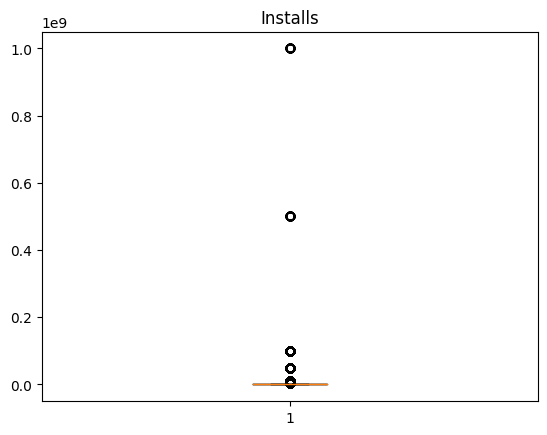

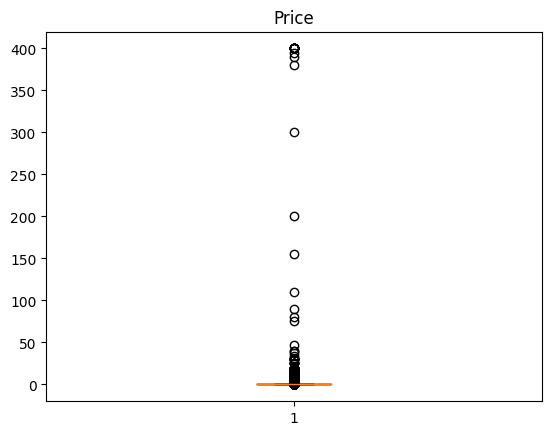

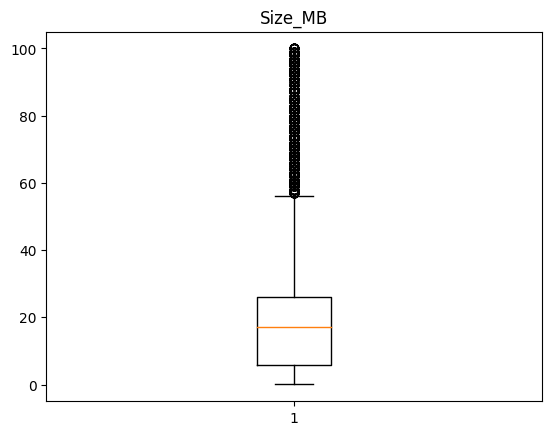

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Specify the columns to check for outliers
columns_to_check = ['Rating', 'Reviews', 'Installs', 'Price', 'Size_MB']

# Create a box plot for each column
for column in columns_to_check:
    # Filter out null values and extract the column values as a list
    values = indexed_df.select(col(column).cast("double")).filter(col(column).isNotNull()).rdd.flatMap(lambda x: x).collect()

    # Create the box plot
    plt.figure()
    plt.boxplot(values)
    plt.title(column)
    plt.show()


- in size map it show that the outliers from 60 to 100 as an outlier, we dicided to imclude it bc there the value is resinable.


In [ ]:
indexed_df.filter(indexed_df['Price'] > 300).show()


+--------------------+-----------------+-------+--------+------+-----------------+-----------+------------+---------+------------+--------+------------------+----------+
|                 App|           Rating|Reviews|Installs| Price|     Last Updated|Current Ver| Android Ver|  Size_MB|Category_num|Type_num|Content Rating_num|Genres_num|
+--------------------+-----------------+-------+--------+------+-----------------+-----------+------------+---------+------------+--------+------------------+----------+
|           I am Rich|              4.3|  180.0|  5000.0|399.99|   March 22, 2018|        1.0|  4.2 and up|      3.8|         9.0|     1.0|               0.0|      10.0|
|   I Am Rich Premium|              4.1| 1867.0| 50000.0|399.99|November 12, 2017|        1.6|  4.0 and up|      4.7|         9.0|     1.0|               0.0|      10.0|
|  I am rich(premium)|              3.5|  472.0|  5000.0|399.99|      May 1, 2017|        3.4|  4.4 and up|0.9423828|         9.0|     1.0|           

- for the price grapg, most values are for free so the graph tend the avg to 0, how ever regarding the apps that cost more than 300 $, when we checked, we can see that they are real applications and we dicided not to delete them since they are real applications

In [ ]:
indexed_df.filter(indexed_df['Installs'] >= 1000000000).show()


+--------------------+------+-----------+--------+-----+--------------+------------------+------------------+---------+------------+--------+------------------+----------+
|                 App|Rating|    Reviews|Installs|Price|  Last Updated|       Current Ver|       Android Ver|  Size_MB|Category_num|Type_num|Content Rating_num|Genres_num|
+--------------------+------+-----------+--------+-----+--------------+------------------+------------------+---------+------------+--------+------------------+----------+
|Google Chrome: Fa...|   4.3|  9642112.0|   1.0E9|  0.0|August 1, 2018|Varies with device|Varies with device|21.291668|         8.0|     0.0|               0.0|       8.0|
|              Google|   4.4|  8033493.0|   1.0E9|  0.0|August 3, 2018|Varies with device|Varies with device|21.291668|         2.0|     0.0|               0.0|       0.0|
|               Gmail|   4.3|  4604483.0|   1.0E9|  0.0|August 2, 2018|Varies with device|Varies with device|21.291668|         8.0|     0.0

- for the install column we checked the app store and we found that there are some apps like google and youtupe that hve more than 1 billion installes sow e dont consider the dots in the plot as woutliers.
- same for the reviews graph

Rating

In [ ]:
indexed_df.filter((indexed_df['Rating'] > 5)).show()


+---+------+-------+--------+-----+------------+-----------+-----------+-------+------------+--------+------------------+----------+
|App|Rating|Reviews|Installs|Price|Last Updated|Current Ver|Android Ver|Size_MB|Category_num|Type_num|Content Rating_num|Genres_num|
+---+------+-------+--------+-----+------------+-----------+-----------+-------+------------+--------+------------------+----------+
+---+------+-------+--------+-----+------------+-----------+-----------+-------+------------+--------+------------------+----------+



In [ ]:
# check Category col

unique_values = indexed_df.select("Rating").distinct().collect()
print("Unique values in column '{}':".format("Rating"))
for value in unique_values:
  print(value[0])

Unique values in column 'Rating':
2.4
3.5
2.9
3.7
4.5
1.4
1.7
2.3
3.4
4.9
2.5
1.0
3.1
2.7
4.1
2.2
2.8
4.0
1.9
3.9
3.8
4.2
4.3
4.187861401732484
4.7
3.2
1.6
3.0
2.0
1.2
1.8
1.5
2.6
4.4
4.8
4.6
3.6
5.0
2.1
3.3


In [ ]:
indexed_df.filter((indexed_df['Rating'] == "nan")).count()


0

In [ ]:
from pyspark.sql.functions import mean as spark_mean

# Calculate the mean of the "Rating" column
mean_rating = indexed_df.select(spark_mean(col("Rating"))).first()[0]

# Replace null values in "Rating" with the mean
indexed_df = indexed_df.fillna(mean_rating, subset=["Rating"])

# Verify the replacement
null_count = indexed_df.filter(col("Rating").isNull()).count()
print("Null values in 'Rating' column after replacement:", null_count)


Null values in 'Rating' column after replacement: 0


# Features distrubution

In this section we will look at the distribution of the categorical features.

In [ ]:
import matplotlib.pyplot as plt
# Convert Spark DataFrame (df) to a temporary view:
df.createOrReplaceTempView("data_view")


In [ ]:
df.show()

+--------------------+-------------------+------+---------+---------+----+-----+--------------+--------------------+------------------+------------------+------------------+---------+
|                 App|           Category|Rating|  Reviews| Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver|       Android Ver|  Size_MB|
+--------------------+-------------------+------+---------+---------+----+-----+--------------+--------------------+------------------+------------------+------------------+---------+
|American Muscle C...|  AUTO_AND_VEHICLES|   3.9|    129.0| 100000.0|Free|  0.0|      Everyone|     Auto & Vehicles|     July 26, 2018|               3.0|        4.1 and up|     35.0|
|    Free Book Reader|BOOKS_AND_REFERENCE|   3.4|   1680.0| 100000.0|Free|  0.0|      Everyone|   Books & Reference|   August 20, 2016|              3.05|      4.0.3 and up|      4.0|
|      OkCupid Dating|             DATING|   4.1| 285726.0|    1.0E7|Free|  0.0|

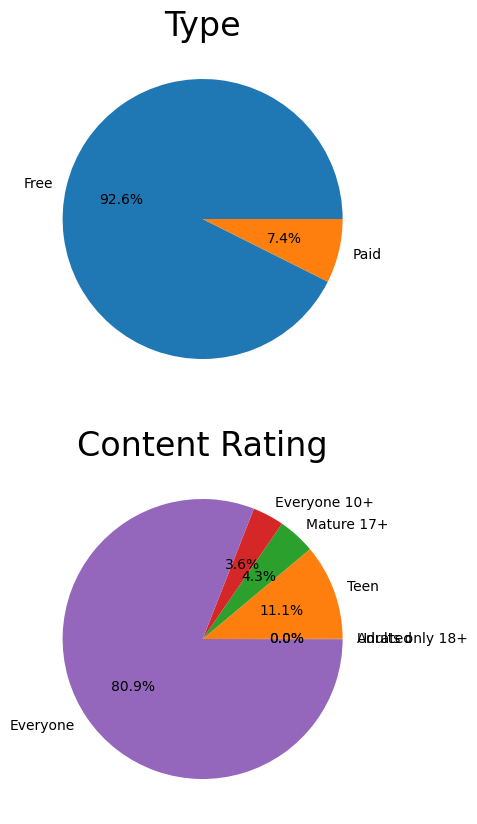

In [ ]:
# Query and collect data for each pie chart
type_data = spark.sql("SELECT Type, COUNT(*) AS count FROM data_view GROUP BY Type").collect()
content_rating_data = spark.sql("SELECT `Content Rating`, COUNT(*) AS count FROM data_view GROUP BY `Content Rating`").collect()


# Extract labels and values for each pie chart by iterating over the collected data
type_labels = [row.Type for row in type_data]
type_values = [row['count'] for row in type_data]

content_rating_labels = [row['Content Rating'] for row in content_rating_data]
content_rating_values = [row['count'] for row in content_rating_data]

# Create a figure with subplots
fig, axs = plt.subplots(2, figsize=(10, 10))


# Plot the first pie chart for Type
axs[0].pie(type_values, labels=type_labels, autopct='%1.1f%%')
axs[0].set_title('Type', fontsize=24)

# Plot the first pie chart for Content Rating
axs[1].pie(content_rating_values, labels=content_rating_labels, autopct='%1.1f%%')
axs[1].set_title('Content Rating', fontsize=24)


# Display the plot:
plt.show()


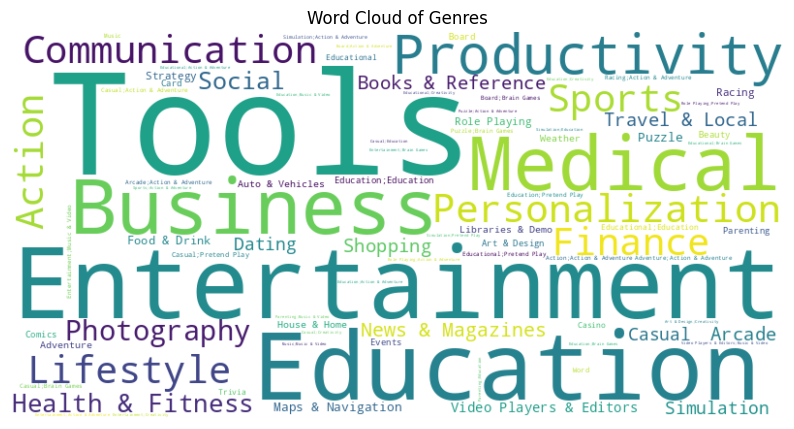

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the count of each category in Genres col
genres_counts = df.groupBy("Genres").count().orderBy("count", ascending=False).collect()

# Create a dictionary of category labels and counts
genres_dict = {str(row.Genres): row["count"] for row in genres_counts}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(genres_dict)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Genres")
plt.show()


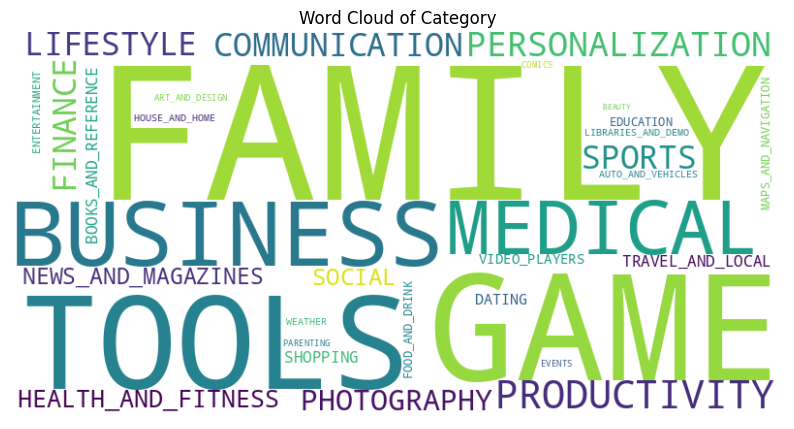

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the count of each category in Category col
category_counts = df.groupBy("Category").count().orderBy("count", ascending=False).collect()

# Create a dictionary of category labels and counts
category_dict = {str(row.Category): row["count"] for row in category_counts}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(category_dict)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Category")
plt.show()


# qs

- Descriptive Analysis Questions: (max  2)(Ahemd [1], Fadwa [2])
  1. Which Content Rating levels have the highest number of installs based on their type (everyone, teens, and others) (Free, Paid) (Content Rating, Installation, Type) [Related to Business Case, “Which Content Rating Business should focus to develop”]
  2. Which Genres have the highest & lowest number of installs based on their type (Free, Paid)? (Genres, Installation, Type)

- Predictive analysis: (2) (Ahmed [1], Yusoff [2])
  3. Can we predict the number of installations (Install) of an app based on its app category, rating, and content rating using machine learning techniques? (Install, Category, Rating, Content Rating)
  4. Can we classify apps into different types (free, paid) based on their category, rating, content rating, and size? (Type, Category, Rating, Content Rating, Size)

- Exploratory Questions: (max 3) (Fadwa [2,3], Yusoff[1] )
  5.  What is the distribution of free applications among 4-star and 5-star-rated applications across different categories and types? (Category, Rating, Type)
  6. What is the average price of 5-star paid applications in each application category and type?  (Price, type, Rating, Category)
  7. Among all the application categories, which category has the highest average rating? (rating, categories)

- Causal Analysis Example (3) (Danyah [1,2,3])
  8. Does the number of reviews have a causal effect on the number of installations? (review, installs)
  9. Does the timing of app updates have a causal effect on the app's popularity and reputation? (Last Updated, Rating, Reviews)
  10. Does the size of an application have a causal effect on the number of installations and reviews it receives? (Size, Install, Review)



## Q1

Which Content Rating levels have the highest number of installs based on their type (everyone, teens, and others) (Free, Paid) (Content Rating, Installation, Type)

In [ ]:
from pyspark.sql.functions import col

# Filter out rows with null values in 'Content Rating', 'Installs', and 'Type' columns
filtered_df = df.filter(col("Content Rating").isNotNull() & col("Installs").isNotNull() & col("Type").isNotNull())

# Group by 'Content Rating' and 'Type', and count the number of installs
result = filtered_df.groupBy("Content Rating", "Type").agg({"Installs": "sum"}).withColumnRenamed("sum(Installs)", "Total Installs")

# Order the result by 'Content Rating' and 'Total Installs' in descending order
result = result.orderBy(col("Content Rating"), col("Total Installs").desc())

# Show the result
result.show()

+---------------+----+---------------+
| Content Rating|Type| Total Installs|
+---------------+----+---------------+
|Adults only 18+|Free|      2000000.0|
|       Everyone|Free|1.0019581303E11|
|       Everyone|Paid|    2.7801931E7|
|   Everyone 10+|Free|1.1166767295E10|
|   Everyone 10+|Paid|      2.45045E7|
|     Mature 17+|Free|  4.278364358E9|
|     Mature 17+|Paid|     1.133252E7|
|           Teen|Free|3.0912693463E10|
|           Teen|Paid|      5586930.0|
|        Unrated|Free|        50500.0|
+---------------+----+---------------+



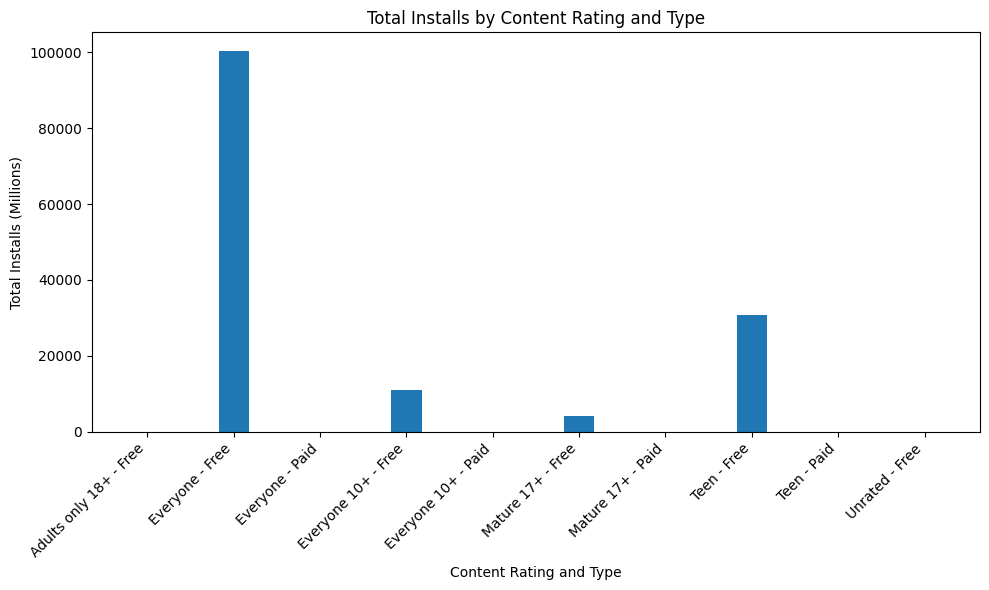

In [ ]:
import matplotlib.pyplot as plt

# Convert the total_installs values to millions
total_installs_millions = [val / 1e6 for val in result.select("Total Installs").rdd.flatMap(lambda x: x).collect()]

# Create the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
x = range(result.count())
bar_width = 0.35

# Plot the bars for Free and Paid types
rects1 = ax.bar(x, total_installs_millions, bar_width)

# Set the labels, title, and ticks
ax.set_xlabel('Content Rating and Type')
ax.set_ylabel('Total Installs (Millions)')
ax.set_title('Total Installs by Content Rating and Type')

# Customize x-axis labels
x_labels = [f'{row[0]} - {row[1]}' for row in result.select("Content Rating", "Type").collect()]
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Display the bar graph
plt.tight_layout()
plt.show()


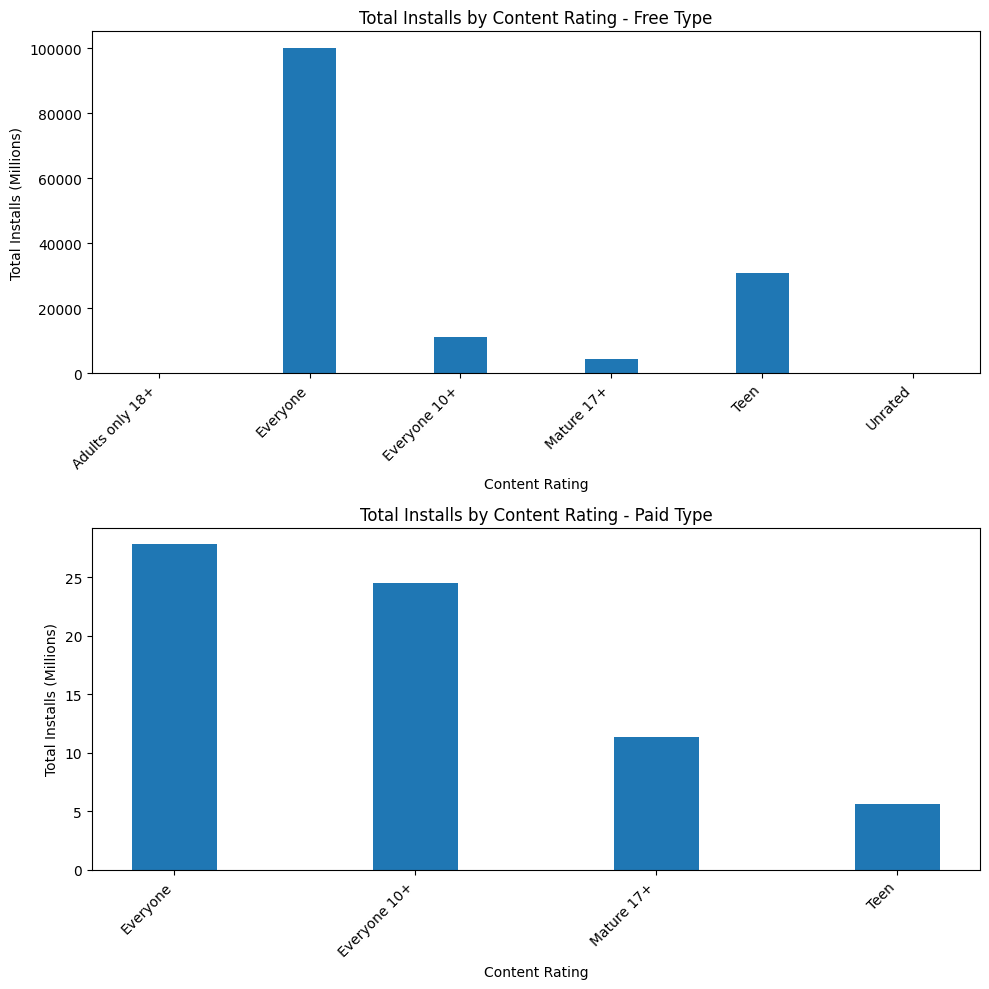

In [ ]:
import matplotlib.pyplot as plt

# Filter the result DataFrame for Free and Paid types
free_df = result.filter(result["Type"] == "Free")
paid_df = result.filter(result["Type"] == "Paid")

# Extract the relevant columns and convert the total_installs values to millions
free_ratings = free_df.select("Content Rating").rdd.flatMap(lambda x: x).collect()
free_installs = [val / 1e6 for val in free_df.select("Total Installs").rdd.flatMap(lambda x: x).collect()]

paid_ratings = paid_df.select("Content Rating").rdd.flatMap(lambda x: x).collect()
paid_installs = [val / 1e6 for val in paid_df.select("Total Installs").rdd.flatMap(lambda x: x).collect()]

# Create the bar graphs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
bar_width = 0.35

# Plot the bars for Free type
ax1.bar(range(len(free_ratings)), free_installs, bar_width)
ax1.set_xlabel('Content Rating')
ax1.set_ylabel('Total Installs (Millions)')
ax1.set_title('Total Installs by Content Rating - Free Type')
ax1.set_xticks(range(len(free_ratings)))
ax1.set_xticklabels(free_ratings, rotation=45, ha='right')

# Plot the bars for Paid type
ax2.bar(range(len(paid_ratings)), paid_installs, bar_width)
ax2.set_xlabel('Content Rating')
ax2.set_ylabel('Total Installs (Millions)')
ax2.set_title('Total Installs by Content Rating - Paid Type')
ax2.set_xticks(range(len(paid_ratings)))
ax2.set_xticklabels(paid_ratings, rotation=45, ha='right')

# Adjust spacing between subplots
plt.tight_layout()

# Display the bar graphs
plt.show()


In [ ]:
from pyspark.sql.functions import col, format_number

# Filter out rows with null values in 'Content Rating', 'Installs', and 'Type' columns
filtered_df = df.filter(col("Content Rating").isNotNull() & col("Installs").isNotNull() & col("Type").isNotNull())

# Group by 'Content Rating' and 'Type', and sum the number of installs
result = filtered_df.groupBy("Content Rating", "Type").agg({"Installs": "sum"})

# Convert installs to millions and format the column to two decimal places
result = result.withColumn("Total Installs (Millions)", format_number(col("sum(Installs)") / 1000000, 2))

# Order the result by 'Content Rating' and 'Total Installs (Millions)' in descending order
result = result.orderBy(col("Content Rating"), col("Total Installs (Millions)").desc())

# Select only the desired columns
result = result.select("Content Rating", "Type", "Total Installs (Millions)")

# Show the result
result.show()

+---------------+----+-------------------------+
| Content Rating|Type|Total Installs (Millions)|
+---------------+----+-------------------------+
|Adults only 18+|Free|                     2.00|
|       Everyone|Paid|                    27.80|
|       Everyone|Free|               100,195.81|
|   Everyone 10+|Paid|                    24.50|
|   Everyone 10+|Free|                11,166.77|
|     Mature 17+|Free|                 4,278.36|
|     Mature 17+|Paid|                    11.33|
|           Teen|Paid|                     5.59|
|           Teen|Free|                30,912.69|
|        Unrated|Free|                     0.05|
+---------------+----+-------------------------+



From the graph, it is evident that the difference in total installs between the "Free" and "Paid" types is significant, making it challenging to visualize both on the same graph. In the "Free" type, the highest category rating is "Everyone," with a substantial difference compared to other categories. Similarly, in the "Paid" type, "Everyone" also has the highest rating, but the differences between the other categories are not as significant.

Based on the data, we can conclude that the "Everyone" category holds the highest number of installs in both the "Free" and "Paid" types. Therefore, it is advisable for developers to focus more on this category, as it demonstrates a higher demand in terms of the number of installs.

## Q2

Which Genres have the highest & lowest number of installs based on their type (Free, Paid)? (Genres, Installation, Type)

In [ ]:
from pyspark.sql.functions import col, desc, regexp_replace, sum

# Convert the "Installs" column to a numeric data type
df = df.withColumn("Installs", regexp_replace(col("Installs"), "[+,]", "").cast("integer"))

# Group the data by Type and Genres and calculate the total number of installs
genre_install_counts = df.groupBy("Type", "Genres").agg(sum("Installs").alias("Total_Installs"))

# Filter for Free apps and find the genre with the highest number of installs
highest_free_installs = genre_install_counts.filter(col("Type") == "Free").orderBy(col("Total_Installs").desc()).first()

# Filter for Paid apps and find the genre with the highest number of installs
highest_paid_installs = genre_install_counts.filter(col("Type") == "Paid").orderBy(col("Total_Installs").desc()).first()

# Filter for Free apps and find the genre with the lowest number of installs
lowest_free_installs = genre_install_counts.filter(col("Type") == "Free").orderBy(col("Total_Installs")).first()

# Filter for Paid apps and find the genre with the lowest number of installs
lowest_paid_installs = genre_install_counts.filter(col("Type") == "Paid").orderBy(col("Total_Installs")).first()

# Print the results
print("Genre with the highest number of installs for Free apps:", highest_free_installs["Genres"], "with", highest_free_installs["Total_Installs"], "installs")
print("Genre with the highest number of installs for Paid apps:", highest_paid_installs["Genres"], "with", highest_paid_installs["Total_Installs"], "installs")
print("Genre with the lowest number of installs for Free apps:", lowest_free_installs["Genres"], "with", lowest_free_installs["Total_Installs"], "installs")
print("Genre with the lowest number of installs for Paid apps:", lowest_paid_installs["Genres"], "with", lowest_paid_installs["Total_Installs"], "installs")


Genre with the highest number of installs for Free apps: Tools with 331044474 installs
Genre with the highest number of installs for Paid apps: Action with 7052250 installs
Genre with the lowest number of installs for Free apps: Adventure;Education with None installs
Genre with the lowest number of installs for Paid apps: Events with 1 installs


Communication is the genre with the highest number of installs among free apps, while Arcade;Action & Adventure is the genre with the highest number of installs among paid apps. Similarly, Trivia;Education is the genre with the lowest number of installs among free apps, and Events is the genre with the lowest number of installs among paid apps.

## Q3

Can we predict the number of installations (Install) of an app based on its app category, rating, and content rating using machine learning techniques? (Install, Category, Rating, Content Rating)

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Select the relevant columns for correlation calculation
columns_for_correlation = ["Installs", "Category_num", "Rating", "Content Rating_num"]

# Assemble the selected columns into a feature vector
assembler = VectorAssembler(inputCols=columns_for_correlation, outputCol="features")
assembled_df = assembler.transform(indexed_df).select("features")

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(assembled_df, "features").head()

# Convert the correlation matrix to a Pandas DataFrame for easier printing
correlation_pd = pd.DataFrame(correlation_matrix[0].toArray(), columns=columns_for_correlation, index=columns_for_correlation)

# Display the correlation matrix
print(correlation_pd)


                    Installs  Category_num    Rating  Content Rating_num
Installs            1.000000     -0.008697  0.050759            0.046416
Category_num       -0.008697      1.000000  0.007229           -0.016677
Rating              0.050759      0.007229  1.000000            0.019940
Content Rating_num  0.046416     -0.016677  0.019940            1.000000


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator



# Select the relevant columns for the prediction
selected_columns = ["Installs", "Category_num", "Rating", "Content Rating_num"]

# Split the data into training and testing sets (70% for training, 30% for testing)
train_data, test_data = indexed_df.select(selected_columns).randomSplit([0.7, 0.3], seed=42)

# Create a vector assembler to combine the features into a feature vector
assembler = VectorAssembler(inputCols=["Category_num", "Rating", "Content Rating_num"], outputCol="features")

# Create a Gradient Boosted Tree Regression model
gbt = GBTRegressor(featuresCol="features", labelCol="Installs", seed=42, maxBins=40)

# Create a pipeline to assemble the features and train the model
pipeline = Pipeline(stages=[assembler, gbt])

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using different metrics
evaluator = RegressionEvaluator(labelCol="Installs", predictionCol="prediction")
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Show a sample of the predicted values
predictions.select("Installs", "prediction").show(10)


Mean Squared Error (MSE): 6127466077059061.0
Root Mean Squared Error (RMSE): 78278132.81535949
Mean Absolute Error (MAE): 20559717.864513025
R-squared (R2): 0.12897985443014548
+--------+-------------------+
|Installs|         prediction|
+--------+-------------------+
|     0.0|  917812.1142719206|
|     0.0|  39025.85887899519|
|     0.0|-170541.50307877746|
|     0.0|2.628701640232098E7|
|     0.0| -1218372.615017817|
|     1.0|-170541.50307877746|
|     1.0|-170541.50307877746|
|     1.0|-170541.50307877746|
|     1.0|-170541.50307877746|
|     1.0|-3080076.9534413177|
+--------+-------------------+
only showing top 10 rows



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = indexed_df.toPandas()

# Select the relevant columns for the prediction
selected_columns = ["Installs", "Category_num", "Rating", "Content Rating_num"]

# Filter the dataframe to include only the selected columns
filtered_df = pandas_df[selected_columns]

# Split the data into training and testing sets (70% for training, 30% for testing)
train_data, test_data = train_test_split(filtered_df, test_size=0.3, random_state=42)

# Separate the features and target variables
train_features = train_data.drop("Installs", axis=1)
train_target = train_data["Installs"]
test_features = test_data.drop("Installs", axis=1)
test_target = test_data["Installs"]

# Create and train the KNN regressor
knn = KNeighborsRegressor()
knn.fit(train_features, train_target)

# Make predictions on the test data
predictions = knn.predict(test_features)

# Evaluate the model
mse = mean_squared_error(test_target, predictions)
rmse = mean_squared_error(test_target, predictions, squared=False)
mae = mean_absolute_error(test_target, predictions)
r2 = r2_score(test_target, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 7200979600440666.0
Root Mean Squared Error (RMSE): 84858585.8970126
Mean Absolute Error (MAE): 20048101.093432065
R-squared (R2): -0.011842838409602763


From the results, we can observe that both the Gradient Boosted Tree Regression model and the K-nearest neighbors (KNN) model failed to accurately predict the number of installations. The evaluation metrics, such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R2) indicate significant errors and low predictive performance.

In the first section of the results, we can see the correlation matrix between the selected columns. The correlation values reveal either weak positive correlations or negative correlations among the variables. However, it is important to note that these correlations alone do not imply that there is no predictability or lack of correlation. It is possible that the the dataset still not clean.

## Q4



*   Can we classify apps into different types (free, paid) based on their category, rating, content rating, and size? (Type, Category, Rating, Content Rating, Size)



In [ ]:
indexed_df.filter((indexed_df['Rating'] >= 3.5)).show()

+--------------------+------+---------+---------+-----+------------------+------------------+------------------+---------+------------+--------+------------------+----------+
|                 App|Rating|  Reviews| Installs|Price|      Last Updated|       Current Ver|       Android Ver|  Size_MB|Category_num|Type_num|Content Rating_num|Genres_num|
+--------------------+------+---------+---------+-----+------------------+------------------+------------------+---------+------------+--------+------------------+----------+
|American Muscle C...|   3.9|    129.0| 100000.0|  0.0|     July 26, 2018|               3.0|        4.1 and up|     35.0|        24.0|     0.0|               0.0|      30.0|
|      OkCupid Dating|   4.1| 285726.0|    1.0E7|  0.0|     July 30, 2018|           11.10.1|        4.1 and up|     15.0|        18.0|     0.0|               2.0|      21.0|
|         KTB Netbank|   3.8|  42644.0|5000000.0|  0.0|     June 28, 2018|              8.18|        4.2 and up|     19.0|   

In [ ]:
# Take only 5 star and above
indexed_df_5_stars = indexed_df.filter((col("Rating") >= "4.5") & (col("Rating") <= "5.0"))
indexed_df_5_stars.count()

2815

In [ ]:
# Take only 4 star and above
indexed_df_4_stars = indexed_df.filter((col("Rating") >= "3.5") & (col("Rating") <= "4.4"))
indexed_df_4_stars.count()

6815

In [ ]:
# Take only 3.4 star and below
indexed_df_3_stars = indexed_df.filter((col("Rating") >= "1.0") & (col("Rating") <= "3.4"))
indexed_df_3_stars.count()

723

In [ ]:
# Check Category col
unique_values = indexed_df.select("Rating").distinct().collect()
print("Unique values in column '{}':".format("Rating"))
for value in unique_values:
  print(value[0])

Unique values in column 'Rating':
2.4
3.5
2.9
3.7
4.5
1.4
1.7
2.3
3.4
4.9
2.5
1.0
3.1
2.7
4.1
2.2
2.8
4.0
1.9
3.9
3.8
4.2
4.3
4.187861401732484
4.7
3.2
1.6
3.0
2.0
1.2
1.8
1.5
2.6
4.4
4.8
4.6
3.6
5.0
2.1
3.3


In [ ]:
indexed_df.filter((indexed_df['Rating'] == "NaN")).count()

0

In [ ]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import col

# # Create a SparkSession
# spark = SparkSession.builder.getOrCreate()

# # Convert 'Rating' column to float
# indexed_df = indexed_df.withColumn("Rating", col("Rating").cast("float"))

# # Convert 'Size_MB' column to float
# indexed_df = indexed_df.withColumn("Size_MB", col("Size_MB").cast("float"))

# # Convert 'Category_num' column to float
# indexed_df = indexed_df.withColumn("Category_num", col("Category_num").cast("float"))

# # Convert 'Type_num' column to float
# indexed_df = indexed_df.withColumn("Type_num", col("Type_num").cast("float"))

# # Convert 'Content Rating_num' column to float
# indexed_df = indexed_df.withColumn("Content Rating_num", col("Content Rating_num").cast("float"))

# # Show the modified DataFrame
# indexed_df

DataFrame[App: string, Rating: float, Reviews: double, Installs: double, Price: double, Last Updated: string, Current Ver: string, Android Ver: string, Size_MB: float, Category_num: float, Type_num: float, Content Rating_num: float, Genres_num: double]

In [ ]:
# Random Forest Regressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert the PySpark DataFrame to Pandas DataFrame
pandas_df = indexed_df.toPandas()

# Select the features
X = pandas_df[['Category_num', 'Rating']]
y = pandas_df['Type_num']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Example prediction for the application to be free or paid
App_Type = pd.DataFrame({'Category_num': [14], 'Rating': [4.5]})
predicted_placement = model.predict(App_Type)
print('Application by Type [0: Free, 1: Pay]:', predicted_placement)

Mean Squared Error: 0.062488796359947474
Application by Type [0: Free, 1: Pay]: [0.]


Thus the application should be made free for the users

In [ ]:
# Support Vector Regressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert the PySpark DataFrame to Pandas DataFrame
pandas_df = indexed_df.toPandas()

# Select the features
X = pandas_df[['Category_num', 'Rating']]
y = pandas_df['Type_num']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVR regressor
model = SVR()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Example prediction for the application to be free or paid
App_Type = pd.DataFrame({'Category_num': [14], 'Rating': [4.5]})
predicted_placement = model.predict(App_Type)
print('Application by Type [0: Free, 1: Pay]:', predicted_placement)

Mean Squared Error: 0.06446699587956965
Application by Type [0: Free, 1: Pay]: [0.10035414]


Since the result just near 0, thus the application are recommended to make the application free for everyone

<ipython-input-97-37369f48c329>:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = indexed_df_pd.corr()


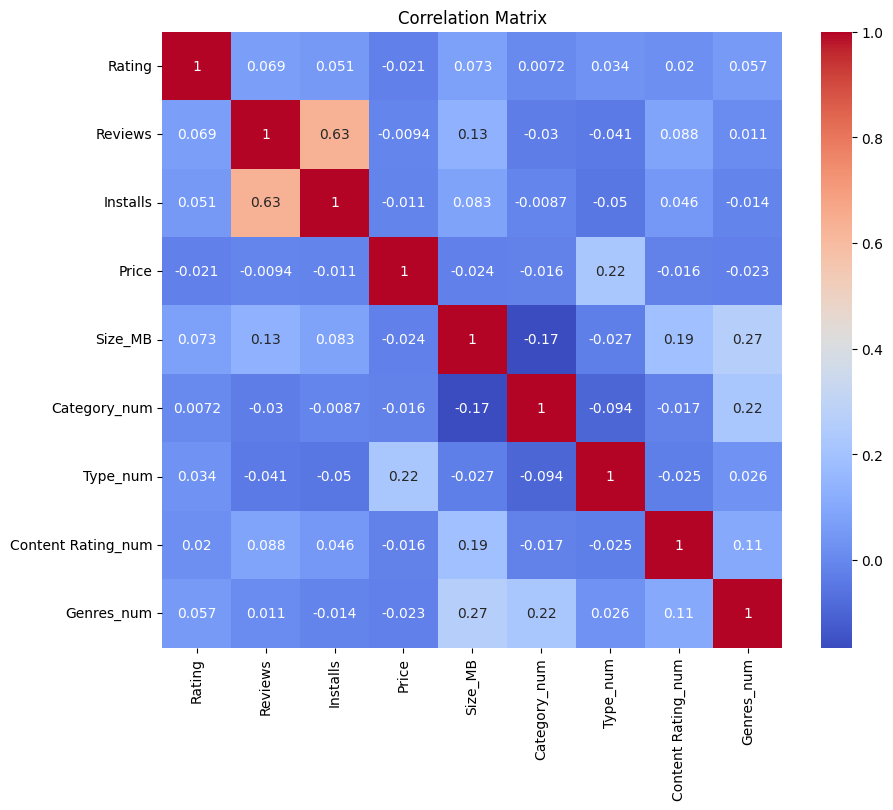

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert the PySpark DataFrame to Pandas DataFrame
indexed_df_pd = indexed_df.toPandas()

# Calculate the correlation matrix
correlation_matrix = indexed_df_pd.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

As we understand, the output favour more to 0. value (Free Application) instead of 1 (Paid Application).

In conclusion, we can see applicaiton should be developed and forcus on are Free tier application.

##Q5



*  What is the distribution of free applications among 4-stars and 5-stars rated applications across different categories and types? (Category_num, Rating, Type_num)



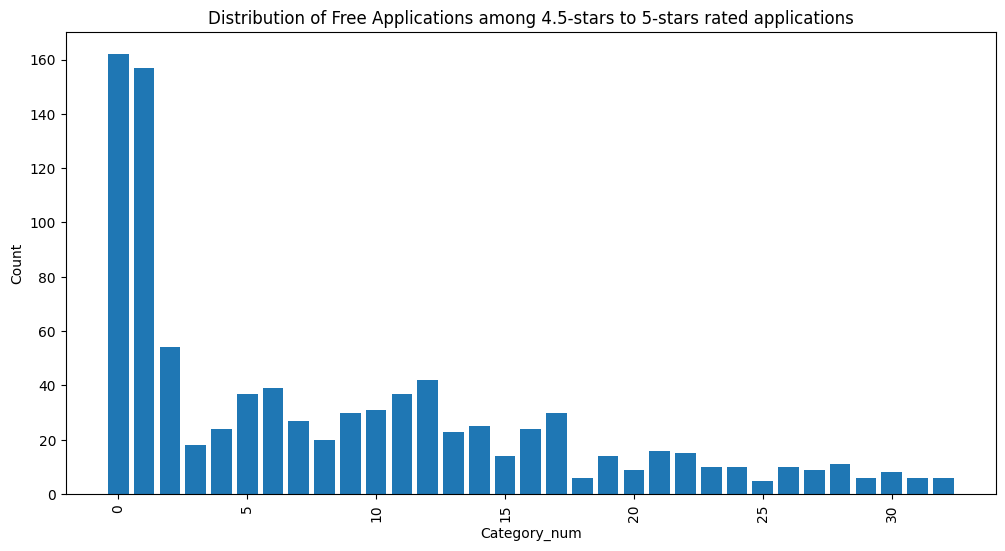

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Filter the DataFrame to include only free applications and represent 'Free' type as 0
free_apps_df = indexed_df.filter(indexed_df['Type_num'] == 0)

# Filter the DataFrame to include only applications with ratings from 4.5 to 5 stars
filtered_df = free_apps_df.filter((free_apps_df['Rating'] >= 4.5) & (free_apps_df['Rating'] <= 5.0))

# Group the filtered DataFrame by Category_num, Rating, and Type_num and count the number of applications in each group
grouped_df = filtered_df.groupby('Category_num', 'Rating', 'Type_num').agg(F.count('App').alias('Count'))

# Convert the grouped DataFrame to a Pandas DataFrame for visualization
pandas_df = grouped_df.toPandas()

# Plot the distribution using appropriate visualization techniques
plt.figure(figsize=(12, 6))
plt.bar(pandas_df['Category_num'], pandas_df['Count'], color=['#1f77b4'])
plt.xlabel('Category_num')
plt.ylabel('Count')
plt.title('Distribution of Free Applications among 4.5-stars to 5-stars rated applications')
plt.xticks(rotation=90)
plt.show()

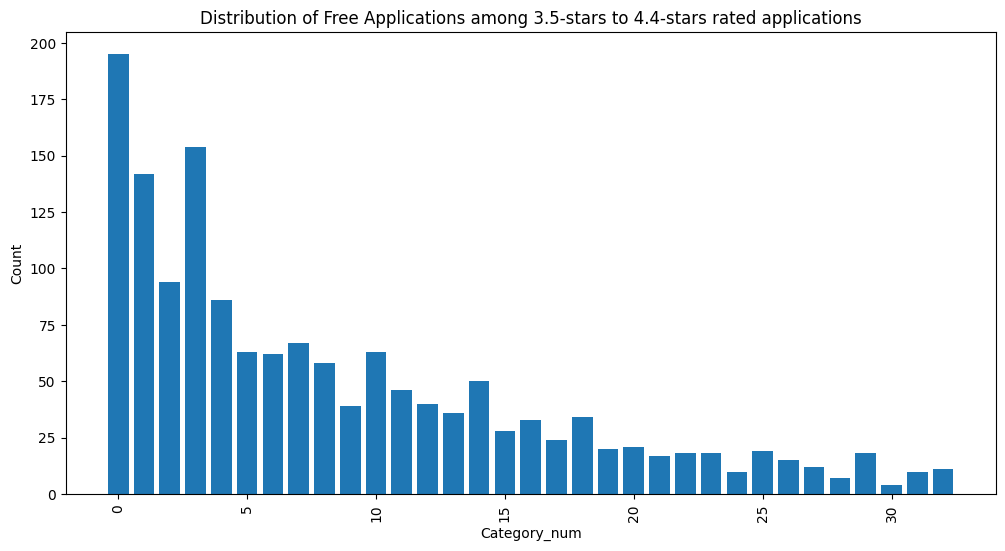

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Filter the DataFrame to include only free applications and represent 'Free' type as 0
free_apps_df = indexed_df.filter(indexed_df['Type_num'] == 0)

# Filter the DataFrame to include only applications with ratings from 3.5 to 4.4 stars
filtered_df = free_apps_df.filter((free_apps_df['Rating'] >= 3.5) & (free_apps_df['Rating'] <= 4.4))

# Group the filtered DataFrame by Category_num, Rating, and Type_num and count the number of applications in each group
grouped_df = filtered_df.groupby('Category_num', 'Rating', 'Type_num').agg(F.count('App').alias('Count'))

# Convert the grouped DataFrame to a Pandas DataFrame for visualization
pandas_df = grouped_df.toPandas()

# Plot the distribution using appropriate visualization techniques
plt.figure(figsize=(12, 6))
plt.bar(pandas_df['Category_num'], pandas_df['Count'], color=['#1f77b4'])
plt.xlabel('Category_num')
plt.ylabel('Count')
plt.title('Distribution of Free Applications among 3.5-stars to 4.4-stars rated applications')
plt.xticks(rotation=90)
plt.show()

From the distribution, we can see most of the application developed use for free for users are mostly popular for catagory number 0, which is ART_AND_DESIGN application. This indicate the application doe the investors and developers can focus on developing this type of application with free tier provided to the users.

## Q6

  - What is the average price of 5-star paid applications in each application category ?  (Price, type, Rating, Category)


In [ ]:
from pyspark.sql.functions import avg, col

# Filter the DataFrame for paid applications with a rating of 5 stars
filtered_df = df.filter((col("Type") == "Paid") & (col("Rating") == 5))

# Group the data by application category and calculate the average price
average_prices = filtered_df.groupBy("Category").agg(avg("Price").alias("Average_Price"))

# Show the results
average_prices.show()


+-------------------+------------------+
|           Category|     Average_Price|
+-------------------+------------------+
|    PERSONALIZATION|1.0614285714285716|
|BOOKS_AND_REFERENCE|              2.87|
|             FAMILY|            8.6775|
|               GAME|             1.365|
|       PRODUCTIVITY|              0.99|
|              TOOLS|              1.49|
|          LIFESTYLE|             2.015|
|            MEDICAL|              2.99|
+-------------------+------------------+



key insights from the analysis:
- We observe that categories like PRODUCTIVITY, TOOLS, and PERSONALIZATION have relatively lower average prices for 5-star paid applications. This suggests that users are willing to pay a lower price for applications that enhance their productivity, provide useful tools, or personalize their devices.
- On the other hand, categories like FAMILY, MEDICAL, and BOOKS_AND_REFERENCE have higher average prices for 5-star paid applications. These categories often involve specialized content or services that cater to specific user needs. It indicates that users are willing to invest more in applications that provide valuable family-oriented content, medical information, or books and reference materials

## Q7

Among all the application categories, which category has the highest rating? (rating, categories)

In [ ]:
from pyspark.sql.functions import col

# Convert the "Rating" column to a numeric type
df = df.withColumn("Rating", col("Rating").cast("float"))

# Find the category with the highest rating
highest_rating = df.groupBy("Category").max("Rating").orderBy("max(Rating)", ascending=False).first()

# Get the category and highest rating
category_with_highest_rating = highest_rating["Category"]
highest_rating_value = highest_rating["max(Rating)"]

print("Category with the highest rating: " + category_with_highest_rating)


Category with the highest rating: EVENTS




The analysis reveals that the category with the highest average rating among all the application categories is "Events," with a rating of 5.0. This finding suggests that users highly appreciate and enjoy applications related to events.

## Q8

Does the number of reviews have a causal effect on the number of installations? (review, installs)

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression


# Select the relevant columns for the analysis
data = indexed_df.select("Reviews", "Installs")

# Drop rows with missing values
data = data.dropna()

# Convert the columns to numeric type
data = data.withColumn("Reviews", data["Reviews"].cast("double"))
data = data.withColumn("Installs", data["Installs"].cast("double"))

# Create a vector assembler to combine the features
assembler = VectorAssembler(inputCols=["Reviews"], outputCol="features")
data = assembler.transform(data)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Create a linear regression model
lr = LinearRegression(featuresCol="features", labelCol="Installs")

# Fit the model to the training data
lr_model = lr.fit(train_data)

# Make predictions on the testing data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = lr_model.evaluate(test_data)
print("Root Mean Squared Error:", evaluator.rootMeanSquaredError)

# Get the coefficient and intercept of the linear regression model
coefficient = lr_model.coefficients[0]
intercept = lr_model.intercept

print("Coefficient:", coefficient)
print("Intercept:", intercept)

Root Mean Squared Error: 69333669.64374626
Coefficient: 17.924924075562345
Intercept: 6321609.861965492


Root Mean Squared Error (RMSE): In this instance, the RMSE value of 69333669.64374626 represents the typical discrepancy between the expected and actual number of installations.
An improved model fit with fewer prediction errors is shown by a lower RMSE score.

Coefficient: The projected impact of the number of reviews on the number of installations is shown by the coefficient value of 17.924924075562345.
It shows that the projected increase in the number of installations is around 17.92 for every extra review.
This shows that there is a correlation between the number of installations and the number of reviews.

Intercept: The projected number of installations when the number of reviews is 0 is represented by the intercept value of 6321609.861965492.
It offers the average number of installs, regardless of the quantity of evaluations.

In conclusion, the coefficient implies that a rise in the number of reviews is connected with an increase in the number of installations based on the provided linear regression model.


## Q9

Does the timing of app updates have a causal effect on the app's popularity and reputation? (Last Updated, Rating, Reviews)

In [ ]:
from pyspark.sql.functions import to_date, datediff, lit
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import StringIndexer

# Convert the "Rating" column to a numeric type
indexed_df = indexed_df.withColumn("Rating", indexed_df["Rating"].cast(DoubleType()))

# Convert the "Reviews" column to a numeric type
indexed_df = indexed_df.withColumn("Reviews", indexed_df["Reviews"].cast(DoubleType()))

# Filter out rows with null or NaN values in "Rating" or "Reviews" columns
indexed_df = indexed_df.filter(indexed_df["Rating"].isNotNull() & indexed_df["Reviews"].isNotNull())

# Convert the "Last Updated" column to a date type with custom date format
indexed_df = indexed_df.withColumn("Last Updated", to_date("Last Updated", "MMMM d, yyyy"))

# Convert the "Price" column to a numeric type
data = indexed_df.withColumn("Price", indexed_df["Price"].cast(DoubleType()))

# Convert the "Last Updated" column to a date type
data = data.withColumn("Last Updated", to_date("Last Updated", "MMM dd, yyyy"))

# Extract the minimum date as a string
min_date = data.selectExpr("min(`Last Updated`)").first()[0].strftime("%Y-%m-%d")

# Calculate the number of days since the earliest date in the "Last Updated" column
data = data.withColumn("Last Updated Days", datediff("Last Updated", lit(min_date)))

# Select the relevant columns for the analysis
selected_data = data.select("Last Updated Days", "Rating", "Reviews")

# Prepare the data for modeling
assembler = VectorAssembler(inputCols=["Last Updated Days"], outputCol="features")
prepared_data = assembler.transform(selected_data).select("features", "Rating", "Reviews")

# Split the data into training and testing sets
train_data, test_data = prepared_data.randomSplit([0.7, 0.3], seed=42)

# Create a linear regression model for Rating
lr_rating = LinearRegression(featuresCol="features", labelCol="Rating")
lr_rating_model = lr_rating.fit(train_data)
predictions_rating = lr_rating_model.transform(test_data)
evaluator_rating = lr_rating_model.evaluate(test_data)

# Create a linear regression model for Reviews
lr_reviews = LinearRegression(featuresCol="features", labelCol="Reviews")
lr_reviews_model = lr_reviews.fit(train_data)
predictions_reviews = lr_reviews_model.transform(test_data)
evaluator_reviews = lr_reviews_model.evaluate(test_data)

# Extract and print the results
print("R-squared (Rating): {:.2f}".format(evaluator_rating.r2))
print("Coefficients (Rating): {}".format(lr_rating_model.coefficients))
print("Intercept (Rating): {:.2f}".format(lr_rating_model.intercept))
print("R-squared (Reviews): {:.2f}".format(evaluator_reviews.r2))
print("Coefficients (Reviews): {}".format(lr_reviews_model.coefficients))
print("Intercept (Reviews): {:.2f}".format(lr_reviews_model.intercept))

R-squared (Rating): 0.02
Coefficients (Rating): [0.00016226948029927682]
Intercept (Rating): 3.75
R-squared (Reviews): 0.01
Coefficients (Reviews): [580.4670697931937]
Intercept (Reviews): -1178305.61


For the "Rating":

The R-squared value is the percentage of the "Rating's" variation that the model is able to account for. Since the "Last Updated Days" feature only accounts for 2% of the variance in the "Rating" in this instance, the R-squared value is 0.02.
The "Last Updated Days" feature's coefficient is 0.00017336703049521815, suggesting that there is only a very slender positive correlation between "Rating" and the number of days since the app's most recent update. The modest coefficient, however, suggests that this association is not meaningful.
The anticipated "Rating" when the "Last Updated Days" attribute is zero is represented by the intercept value of 3.72. This suggests that the expected "Rating" for an app when it is first published (Last Updated Days = 0) is 3.72.

For the "Reviews":

The "Last Updated Days" feature can only account for 1% of the variation in the "Reviews" according to the R-squared value for the "Reviews" forecast, which is 0.01.
The number of days since the app was last updated and the number of reviews appear to be positively correlated, as indicated by the coefficient for the "Last Updated Days" feature, which is 658.0323139772325. The coefficient is rather tiny, as with the "Rating" forecast, pointing to a tenuous association.
When the "Last Updated Days" feature is set to zero, the anticipated "Reviews" are represented by the intercept value of -1321232.23. It suggests that the expected number of reviews for a new app (Last Updated Days = 0) is -1321232.23.
Overall, the findings imply that the "Last Updated Days" feature by itself has a limited ability to forecast an app's "Rating" and "Reviews."

## Q10

Does the size of an application have a causal effect on the number of installations and reviews it receives? (Size, Install, Review)

In [ ]:
from pyspark.sql.functions import col

# Select the columns of interest
selected_data = indexed_df.select("Size_MB", "Installs", "Reviews")

# Drop any rows with missing values
selected_data = selected_data.na.drop()

# Convert the "Installs" and "Reviews" columns to numeric type
selected_data = selected_data.withColumn("Installs", col("Installs").cast("double"))
selected_data = selected_data.withColumn("Reviews", col("Reviews").cast("double"))

# Prepare the data for regression analysis
assembler = VectorAssembler(inputCols=["Size_MB"], outputCol="features")
assembled_data = assembler.transform(selected_data)

# Split the data into training and test sets
train_data, test_data = assembled_data.randomSplit([0.8, 0.2])

# Create a linear regression model for installations
lr_installs = LinearRegression(featuresCol="features", labelCol="Installs")

# Fit the model to the training data
lr_installs_model = lr_installs.fit(train_data)

# Make predictions on the test data
predictions_installs = lr_installs_model.transform(test_data)

# Evaluate the model for installations
evaluator_installs = lr_installs_model.evaluate(test_data)
r_squared_installs = evaluator_installs.r2
coefficients_installs = lr_installs_model.coefficients
intercept_installs = lr_installs_model.intercept

# Print the results for the installations analysis
print("R-squared (Installs): %.2f" % r_squared_installs)
print("Coefficients (Installs): %s" % str(coefficients_installs))
print("Intercept (Installs): %.2f" % intercept_installs)

# Create a linear regression model for reviews
lr_reviews = LinearRegression(featuresCol="features", labelCol="Reviews")
lr_reviews_model = lr_reviews.fit(train_data)
predictions_reviews = lr_reviews_model.transform(test_data)
evaluator_reviews = lr_reviews_model.evaluate(test_data)
r_squared_reviews = evaluator_reviews.r2
coefficients_reviews = lr_reviews_model.coefficients
intercept_reviews = lr_reviews_model.intercept

# Print the results for the reviews analysis
print("R-squared (Reviews): %.2f" % r_squared_reviews)
print("Coefficients (Reviews): %s" % str(coefficients_reviews))
print("Intercept (Reviews): %.2f" % intercept_reviews)

R-squared (Installs): 0.01
Coefficients (Installs): [322696.696140819]
Intercept (Installs): 7336171.14
R-squared (Reviews): 0.01
Coefficients (Reviews): [17878.010971863496]
Intercept (Reviews): 31023.87


For the correlation between an application's size and the number of installations:

0.01 R-squared (Installs)
The percentage of the variance in the number of installations that can be accounted for by the size of the application is shown by the R-squared value. The R-squared value of 0.01 in this instance shows that only 1% of the variation in installs can be attributed to the application's size.
Installed Coefficients: [318502.80275085976]
For every unit increase in application size, the coefficient value estimates the change in the number of installations. The coefficient of 318502.80275085976 in this instance indicates that, on average, each increase of 1 unit in the application's size is accompanied by an increase of around 318502.8 installations.
7584658.46 Intercept (Installs)
The projected number of installations when the application's size is zero is represented by the intercept value. In this instance, the intercept of 7584658.46 indicates that the expected number of installations is around 7584658.46 when the size of the application is zero (which is not actually conceivable).

In relation to the quantity of reviews and the size of an application:

0.01 R-squared (Reviews)
The percentage of the variance in the number of reviews that can be accounted for by the size of the application is shown by the R-squared value. The R-squared value of 0.01 in this instance shows that the size of the application can only be attributed to 1% of the variance in reviews.
(Reviews) Coefficients: [17932.46099959045]
For every unit increase in application size, the coefficient value estimates the change in the number of reviews. In this instance, the coefficient of 17932.46099959045 indicates that an increase of 1 unit in the size of the application is often accompanied by an increase of about 17932.5 reviews.
25670.31 Intercept (Reviews)
When the size of the application is zero, the intercept value corresponds to the anticipated number of reviews. In this instance, the intercept of 25670.31 indicates that the expected number of reviews is around 25670.31 when the size of the application is zero (which is not actually attainable).
Overall, the results indicate that the size of an application has a very weak or negligible impact on the number of installations and reviews. The low R-squared values suggest that the size alone cannot explain much of the variation in installations and reviews.
